In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend
import matplotlib.pyplot as plt
import numpy as np

#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.utils import np_utils

C:\Programs\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [3]:
# Каталог с данными для обучения
train_dir = 'numbers/train'
# Каталог с данными для проверки
val_dir = 'numbers/val'
# Каталог с данными для тестирования
test_dir = 'numbers/test'
# Размеры изображения
img_width, img_height = 28, 28
# Размерность тензора на основе изображения для входных данных в нейронную сеть
input_shape = (img_width, img_height, 3)
# Количество эпох
epochs = 30
# Размер мини-выборки
batch_size = 16
# Количество изображений для обучения
nb_train_samples = 25506
# Количество изображений для проверки
nb_validation_samples = 4500
# Количество изображений для тестирования
nb_test_samples = 4500

In [4]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical')

Found 25506 images belonging to 9 classes.


In [5]:
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 4500 images belonging to 9 classes.


In [6]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 4500 images belonging to 9 classes.


In [7]:
# Создаем последовательную модель
model = Sequential()

model.add(Conv2D(75, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(100, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Методу fit_generator передаем два генератора: train_generator с данными для обучения и val_generator с данными для проверки. Обучение выполняется в течение 30 эпох.

Генераторы в Keras устроены так, что могут выдавать изображения бесконечно. После того, как изображения в каталоге закончатся, происходит переход в начало каталога, и генератор начинает работать снова. Поэтому нужно указать, сколько будет обращений к генератору на каждой эпохе обучения. Для этого используется параметры steps_per_epoch (данные для обучения) и validation_steps (данные для проверки). За одно обращение генератор выдает не одно изображение, а несколько, в соответствии с размером его мини-выборки (batch_size). Чтобы рассчитать количество обращений к генератору, при котором мы сможем получить все изображения из набора данных по одному разу, мы делим количество изображений в наборе на размер мини-выборки.

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
#early_stopping_callback = EarlyStopping(monitor='val_acc', patience=4)

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=3,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/3
1594/1594 [==============================] - 54s 34ms/step - loss: 0.1338 - acc: 0.9650 - val_loss: 0.0381 - val_acc: 0.9944
Epoch 2/3
1594/1594 [==============================] - 50s 32ms/step - loss: 0.0437 - acc: 0.9936 - val_loss: 0.0363 - val_acc: 0.9964
Epoch 3/3
1594/1594 [==============================] - 51s 32ms/step - loss: 0.0434 - acc: 0.9947 - val_loss: 0.0439 - val_acc: 0.9938


In [10]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)
print("Аккуратность на тестовых данных: %.2f%%" % (scores[1]*100))

Аккуратность на тестовых данных: 99.35%


In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 75)        5700      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 75)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 100)         187600    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 100)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 100)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
__________

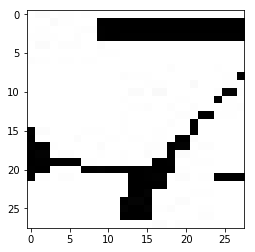

In [13]:
x = image.load_img("1.jpg", target_size=(28, 28))
plt.imshow(x)
plt.show()
x = image.img_to_array(x)
x = x.astype('float32')
x /= 255
#x = x[np.newaxis, :, :, :]
x = np.expand_dims(x, axis=0)
prediction = model.predict(x)

In [14]:
print(np.argmax(prediction) + 1)

7


In [15]:
# Генерируем описание модели в формате json
model_json = model.to_json()
# Записываем модель в файл
json_file = open("my_model.json", "w")
json_file.write(model_json)
json_file.close()

In [16]:
model.save_weights("my_model.h5")

Для загрузки сети, как и для сохранения, нам необходимо выполнить две операции:

    Загрузить данные об архитектуре сети.
    Загрузить данные о весах.


In [10]:
from tensorflow.python.keras.models import model_from_json

# Загружаем данные об архитектуре сети из файла json
json_file = open("my_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
# Создаем модель на основе загруженных данных
loaded_model = model_from_json(loaded_model_json)
# Загружаем веса в модель
loaded_model.load_weights("my_model.h5")


Перед использованием модели, ее обязательно нужно скомпилировать:

In [11]:
# Компилируем модель
loaded_model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])
# Проверяем модель на тестовых данных
scores = loaded_model.evaluate_generator(test_generator, nb_test_samples // batch_size)
print("Точность модели на тестовых данных: %.2f%%" % (scores[1]*100))

Точность модели на тестовых данных: 99.76%
